In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pymorphy3

# Инициализация необходимых объектов для обработки текста
morph_analyzer = pymorphy3.MorphAnalyzer()
    
class CreateDataset:
    def __init__(self):

        self.practice = {'задача', 'кейс'}
        self.theory = {'знания', 'лекция', 'материал'}
        self.technology = {
            'go', 'golang', 'java', 'javascript',
            'kotlin', 'php', 'python', 'rust',
            'typescript', 'c', 'pascal', 'flask', 'django', 'data', 'science', 'sql', 'html', 'css', 'json', 'js',
            'typescript', 'matplotlib', 'pandas', 'seaborn', 'plotly', 'numpy', 'голанг', 'паскаль', 'джава',
            'джаваскрипт', 'питон', 'пхп',
            'си', 'джанго', 'фласк', 'ооп'}
        self.teacher = {'лектор', 'учитель', 'профессор', 'наставник'}
        self.relevance = {'полезный', 'современный', 'релевантный', 'новый', 'старый', 'устарел'}

        # Список ключевых тем
        self.topic_keywords = ['Практика', 'Теория', 'Преподаватель', 'Технологии', 'Актуальность']
        self.topics = {keyword: {keyword.lower()} for keyword in
                       self.topic_keywords}

        # Обновление словаря ключевых тем с учетом различных форм
        self.topics['Практика'].update(self.practice)
        self.topics['Теория'].update(self.theory)
        self.topics['Преподаватель'].update(self.teacher)
        self.topics['Технологии'].update(self.technology)
        self.topics['Актуальность'].update(self.relevance)

    def names_in_text(self, text: str) -> bool:
        """
        Функция для извлечения имен преподавателей из текста
        :param text: Исходный текст
        :return: True, если найдено хотя бы одно имя, иначе False
        """
        stop_names = frozenset('паскаль')
        for word in text:
            if word not in stop_names:
                parse = morph_analyzer.parse(word)[0]
                tag = parse.tag
                if ('Name' in tag or 'Surn' in tag) and parse.score >= 0.8:
                    return True
        return False

    def automatic_annotation(self, df: pd.DataFrame) -> pd.DataFrame:
        """Автоматическая разметка обучающего набора данных"""
        data_all = {topic: [] for topic in self.topic_keywords}
        data_index = set()

        for idx, row in tqdm(df.iterrows(), total=len(df)):
            preprocessed_text = row['PreprocessedText']
            data = []
            for key, keywords in self.topics.items():
                if any(True for keyword in keywords for word in preprocessed_text if fuzz.ratio(word, keyword) > 67):
                    data_index.add(idx)
                    data.append(1)
                elif key == 'Преподаватель' and self.names_in_text(preprocessed_text):
                    # Дополнительная проверка на имена
                    data_index.add(idx)
                    data.append(1)
                else:
                    # Если текст не относится к категории
                    data.append(0)
            if sum(data) > 0:
                # idx,Практика,Теория,Преподаватель,Технологии,Актуальность
                # {id: [], 
                for i, key in enumerate(self.topic_keywords):
                    data_all[key].append(data[i])
        return pd.DataFrame(data_all, index=sorted(data_index))

In [2]:
import pandas as pd
from thefuzz import fuzz  # Новая версия библиотеки fuzzywuzzy
import nltk

# Загрузка необходимых данных для NLTK
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# from utils import CreateDataset

# Загрузка стоп-слов
stop_words = stopwords.words('russian')

# Загрузка данных
df = pd.read_csv('train_reviews.csv', index_col=0)
df['Reviews'] = df['Reviews'].astype(str)

# Замена кириллической 'с' на латинскую
df['Reviews'] = df['Reviews'].apply(
    lambda x: x.replace('1с', '1c').replace('с#', 'c#').replace('с+', 'c+').replace('Ё', 'Е').replace(
        '1С', '1C').replace('С#', 'C#').replace('С+', 'C+'))


class TextProcessor:
    def preprocess(self, text: str) -> list[str]:
        """
        Предобрабатывает текст, токенизируя, лемматизируя и удаляя стоп-слова.

        :param text: Входной текст, который необходимо предобработать.
        :return: Список предобработанных слов.
        """
        tokens = word_tokenize(text.lower())
        filtered_tokens = [
            normalized_word
            for word in tokens
            if (normalized_word := morph_analyzer.parse(self._remove_symbols(word))[0].normal_form) not in stop_words
        ]

        filtered_tokens = " ".join(filtered_tokens).replace('ё', 'е').split()  # Удаление лишних пробелов
        return filtered_tokens

    @staticmethod
    def _remove_symbols(text: str) -> str:
        """Удаляет все символы и цифры из строки."""
        clean_text = "".join(char if char.isalnum() and not char.isdigit() else " " for char in text)
        return clean_text

[nltk_data] Downloading package stopwords to /home/guru-
[nltk_data]     proger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/guru-
[nltk_data]     proger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Обработка текста

In [3]:
text_processor = TextProcessor()

# Применение предобработки к отзывам
df['PreprocessedText'] = df['Reviews'].apply(text_processor.preprocess)

# Создание списка всех стеммированных слов
all_words = [word for sublist in df['PreprocessedText'] for word in sublist]
unique_words = pd.Series(all_words).value_counts()

# Создание DataFrame с размеченными данными
create_dataset = CreateDataset()
df_dataset_index = create_dataset.automatic_annotation(df)

100%|██████████| 4576/4576 [00:09<00:00, 481.22it/s]


Просмотр размеченных текстов

Всего размеченных текстов - 2380
Практика - 1072
Теория - 1022
Преподаватель - 781
Технологии - 491
Актуальность - 842


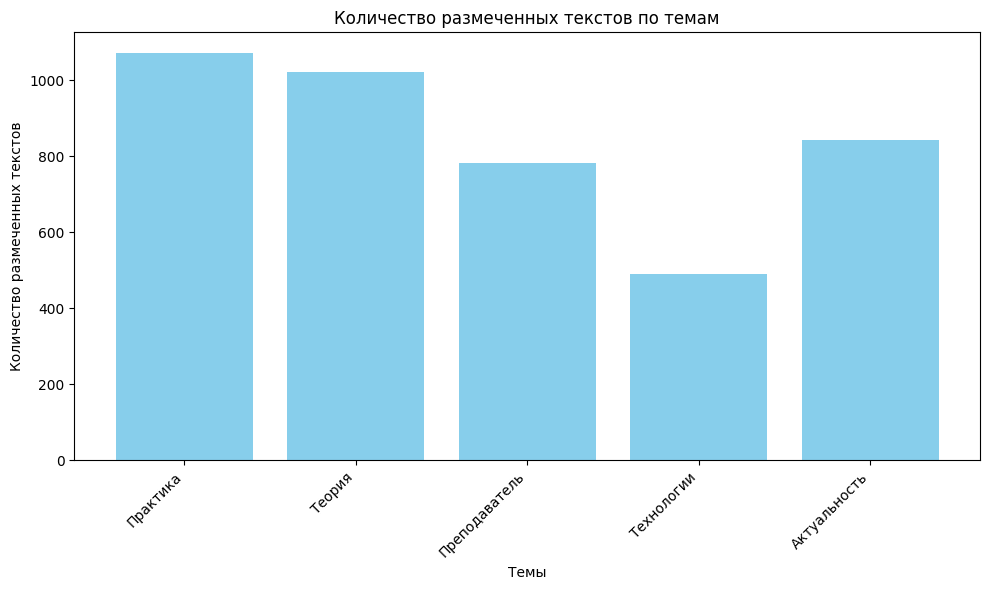

In [4]:
import matplotlib.pyplot as plt

print('Всего размеченных текстов -', len(df_dataset_index))
for t in create_dataset.topic_keywords:
    print(t, '-', len(df_dataset_index[df_dataset_index[t] == 1]))

# Создание списков для тем и их количества
topics = create_dataset.topic_keywords
counts = [len(df_dataset_index[df_dataset_index[t] == 1]) for t in topics]

# Визуализация
plt.figure(figsize=(10, 6))
plt.bar(topics, counts, color='skyblue')
plt.xlabel('Темы')
plt.ylabel('Количество размеченных текстов')
plt.title('Количество размеченных текстов по темам')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Размеченный и обработанный датасет

In [5]:
df_new: pd.DataFrame = df.loc[df_dataset_index.index]
for topic in create_dataset.topic_keywords:
    df_new[topic] = df_dataset_index[topic]
df_new['PreprocessedText'] = df_new['PreprocessedText'].apply(lambda x: " ".join(x))

Векторизация текста

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score

# Векторизация текста
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(df_new['PreprocessedText'])
y = df_new.drop(['PreprocessedText', 'Reviews'], axis=1)
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, df_new[
    ['Практика', 'Теория', 'Преподаватель', 'Технологии', 'Актуальность']], test_size=0.3, random_state=42)


Обучение модели

In [7]:
# Используем многоцелевой классификатор
model = MultiOutputClassifier(DecisionTreeClassifier())
model.fit(X_train, y_train)

# Прогнозируем на тестовых данных
y_pred = model.predict(X_test)
# Оценка модели
print(classification_report(y_test, y_pred, target_names=y.columns, zero_division=0))
print(model.score(X_test, y_test))
print(f1_score(y_test, y_pred, average='macro'))

               precision    recall  f1-score   support

     Практика       1.00      0.99      1.00       321
       Теория       0.99      0.98      0.98       318
Преподаватель       0.94      0.89      0.92       241
   Технологии       0.83      0.75      0.79       158
 Актуальность       0.99      0.95      0.97       237

    micro avg       0.97      0.93      0.95      1275
    macro avg       0.95      0.91      0.93      1275
 weighted avg       0.96      0.93      0.95      1275
  samples avg       0.94      0.94      0.93      1275

0.8277310924369747
0.931059441496864


Проверка тестового текста

In [8]:
test_review = 'Спасибо всем! Мне очень понравилось обучение питону. Курс не устареет ещё очень долго)'
test_review = (text_processor.preprocess(test_review))
test_review = " ".join(test_review)
new_vector = vectorizer.transform(pd.Series(test_review))
test_pred = model.predict(new_vector)
for i, k in enumerate(create_dataset.topic_keywords):
    print(k, ':', test_pred[0][i])

Практика : 0
Теория : 0
Преподаватель : 0
Технологии : 1
Актуальность : 1


Cоздание ответатвет на тестовый файл

In [9]:
df_test = pd.read_csv('test_reviews.csv', index_col=0)
df_test['Reviews'] = df_test['Reviews'].astype(str)
df_test['Pred'] = df_test['Reviews'].apply(lambda x: " ".join(text_processor.preprocess(x)))
test_vector = vectorizer.transform(df_test['Pred'])

In [10]:
test_predict = pd.DataFrame(model.predict(test_vector))

In [11]:
for i, k in enumerate(create_dataset.topic_keywords):
    df_test[k.lower()] = test_predict[i]
answer = df_test.drop('Pred', axis=1)
answer.to_csv('answer.csv')